# Stage 2: Feature Engineering / Extraction

In [18]:
# ===== Standard Library =====
import os
import sys

# Add ../src to path
sys.path.append("../src")
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

# ===== Third-Party Libraries =====
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ===== Local Modules =====
from audio.io import load_wav_scipy as load_audio

from features.feature_pair_tables import (
    build_heart_feature_table,
    build_lung_feature_table,
    build_feature_pairs_from_joined_df as extract_features_from_pairs,
)
from features.feature_pipeline import extract_all_features, plot_feature_correlation

from metadata.joins import inner_join
from metadata.loading import load_datasets

from stats.anova import one_way_anova_by_factor
from stats.paired import paired_statistical_comparison


In [3]:
datasets = load_datasets()

print(f'\nDatasets: {list(datasets.keys())}')
datasets['heart_data'].head()

Loaded 50 entries from /Users/xanderyoon/School/Fall '25/ISYE 6416/Final Project copy/data/heart_sounds/HS.csv
Loaded 50 entries from /Users/xanderyoon/School/Fall '25/ISYE 6416/Final Project copy/data/lung_sounds/LS.csv
Loaded 145 entries from /Users/xanderyoon/School/Fall '25/ISYE 6416/Final Project copy/data/mixed_sounds/heart_ref/Mix_HS.csv
Loaded 145 entries from /Users/xanderyoon/School/Fall '25/ISYE 6416/Final Project copy/data/mixed_sounds/lung_ref/Mix_LS.csv
Loaded 145 entries from /Users/xanderyoon/School/Fall '25/ISYE 6416/Final Project copy/data/mixed_sounds/mixed_ref/Mix.csv

Datasets: ['heart_data', 'lung_data', 'mix_heart_data', 'mix_lung_data', 'mixed_data']


,gender,heart_sound_type,location,heart_sound_id,filename
0,F,Normal,RC,F_N_RC,../data/heart_sounds/wav/F_N_RC.wav
1,F,Normal,LC,F_N_LC,../data/heart_sounds/wav/F_N_LC.wav
2,M,Normal,RUSB,M_N_RUSB,../data/heart_sounds/wav/M_N_RUSB.wav
3,F,Normal,LUSB,F_N_LUSB,../data/heart_sounds/wav/F_N_LUSB.wav
4,F,Normal,LLSB,F_N_LLSB,../data/heart_sounds/wav/F_N_LLSB.wav


In [4]:
feature_rows = []
sample_paths = {
    "mix_heart": datasets['mix_heart_data'].iloc[0]['heart_ref_file'],
    "mix_lung": datasets['mix_lung_data'].iloc[0]['lung_ref_file'],
    "mixed": datasets['mixed_data'].iloc[0]['mixture_file']
}

for name, path in sample_paths.items():
    sr, x = load_audio(path)
    feats = extract_all_features(x, sr)
    feats["sample_type"] = name
    feature_rows.append(feats)

df_features = pd.DataFrame(feature_rows)
df_features = df_features.set_index("sample_type")
df_features

,rms,zcr,duration,centroid,bandwidth,rolloff,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,...,mfcc9_std,mfcc10_std,mfcc11_std,mfcc12_std,mfcc13_std,wavelet_energy_0,wavelet_energy_1,wavelet_energy_2,wavelet_energy_3,wavelet_energy_4
sample_type,,,,,,,,,,,,,,,,,,,,,
mix_heart,0.086269,0.116364,15.0,381.281186,215.629616,595.256224,-183.851639,234.077286,-39.823856,-44.216351,...,8.120789,4.020751,3.699964,4.169220,2.678994,0.067357,0.298628,0.478326,0.149682,0.006007
mix_lung,0.136921,0.069377,15.0,183.162118,189.970171,296.775689,-264.070526,202.794785,38.073292,-2.596217,...,6.310082,10.010229,6.432793,7.005819,4.237238,0.631708,0.124789,0.197189,0.044806,0.001508
mixed,0.194467,0.045853,15.0,178.193241,198.286695,332.395392,-218.560379,232.089645,7.096382,-6.014032,...,6.268880,3.876486,2.920123,4.018775,2.647510,0.873610,0.072857,0.047290,0.005965,0.000278


## Dataset comparisons

In [5]:
merged_hs = inner_join(
    single_df=datasets['heart_data'],
    mixed_df=datasets['mix_heart_data'],
    reference_col="heart_ref_file",
    join_keys=["gender", "heart_sound_type", "location"]
)
merged_ls = inner_join(
    single_df=datasets['lung_data'],
    mixed_df=datasets['mix_lung_data'],
    reference_col="lung_ref_file",
    join_keys=["gender", "lung_sound_type", "location"]
)

merged_hs.head()
# merged_ls.head()


Matched rows: 29
Matched rows: 45


,gender,heart_sound_type,location,heart_sound_id,single_source_filename,mixed_source_filename
0,F,Normal,LC,F_N_LC,../data/heart_sounds/wav/F_N_LC.wav,../data/mixed_sounds/heart_ref/wav/H0085.wav
1,F,Normal,Apex,F_N_A,../data/heart_sounds/wav/F_N_A.wav,../data/mixed_sounds/heart_ref/wav/H0133.wav
2,F,Mid Systolic Murmur,Apex,F_MSM_A,../data/heart_sounds/wav/F_MSM_A.wav,../data/mixed_sounds/heart_ref/wav/H0095.wav
3,M,Normal,LC,M_N_LC,../data/heart_sounds/wav/M_N_LC.wav,../data/mixed_sounds/heart_ref/wav/H0039.wav
4,F,Late Systolic Murmur,LUSB,F_LSM_LUSB,../data/heart_sounds/wav/F_LSM_LUSB.wav,../data/mixed_sounds/heart_ref/wav/H0001.wav


In [6]:
hs_feat_pairs = extract_features_from_pairs(merged_hs, "heart")
ls_feat_pairs = extract_features_from_pairs(merged_ls, "lung")

hs_feat_pairs.head()
# ls_feat_pairs.head()

Extracting features (lung): 100%|██████████| 45/45 [00:01<00:00, 36.53it/s]


,heart_single_rms,heart_single_zcr,heart_single_duration,heart_single_centroid,heart_single_bandwidth,heart_single_rolloff,heart_single_mfcc1_mean,heart_single_mfcc2_mean,heart_single_mfcc3_mean,heart_single_mfcc4_mean,...,heart_mixed_mfcc9_std,heart_mixed_mfcc10_std,heart_mixed_mfcc11_std,heart_mixed_mfcc12_std,heart_mixed_mfcc13_std,heart_mixed_wavelet_energy_0,heart_mixed_wavelet_energy_1,heart_mixed_wavelet_energy_2,heart_mixed_wavelet_energy_3,heart_mixed_wavelet_energy_4
0,0.061309,0.027596,15.0,136.024147,201.855902,237.850900,-346.822113,185.239883,40.617916,1.744687,...,3.400508,3.178185,2.461815,2.987671,3.671264,0.962763,0.031046,0.004826,0.001295,0.000071
1,0.096128,0.037821,15.0,184.848098,226.348472,354.061838,-279.270996,192.271408,38.352264,-12.076647,...,3.572095,3.454824,2.362326,2.908766,3.001126,0.906976,0.057842,0.028402,0.006573,0.000207
2,0.085036,0.044007,15.0,207.023906,272.952839,399.579582,-231.546524,161.170563,33.050884,-3.104253,...,5.864887,4.478594,3.009389,3.668566,3.010038,0.913024,0.056751,0.025599,0.004325,0.000302
3,0.115344,0.043229,15.0,223.079288,242.881100,425.632283,-202.182693,192.413437,16.758661,-12.395411,...,4.567251,4.702919,3.551107,4.234048,3.219483,0.816233,0.083805,0.070768,0.027871,0.001324
4,0.086269,0.116364,15.0,381.281186,215.629616,595.256224,-183.851639,234.077286,-39.823856,-44.216351,...,8.120789,4.020751,3.699964,4.169220,2.678994,0.067357,0.298628,0.478326,0.149682,0.006007


In [7]:
hs_stats = paired_statistical_comparison(hs_feat_pairs, "heart")
ls_stats = paired_statistical_comparison(ls_feat_pairs, "lung")

for name, df in [("Heart", hs_stats), ("Lung", ls_stats)]:
    if df["significant_0.05"].any():
        print(f"{name}: Significant difference found.")
    else:
        print(f"{name}: No significant differences.")


/Users/xanderyoon/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/Users/xanderyoon/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


Heart: No significant differences.
Lung: No significant differences.


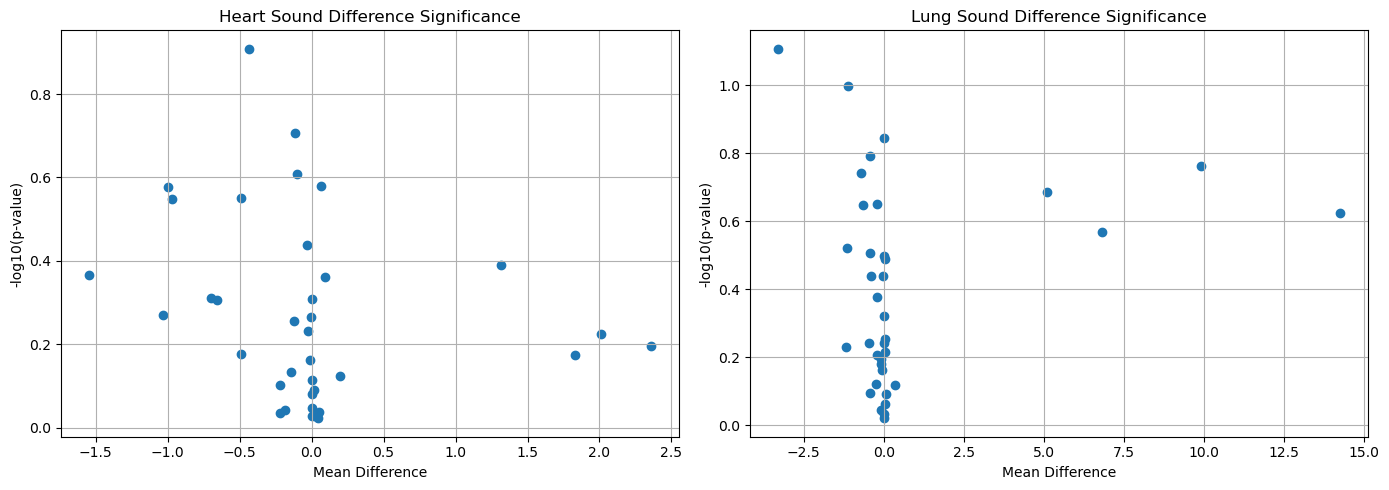

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (df, title) in zip(
    axes,
    [
        (hs_stats, "Heart Sound Difference Significance"),
        (ls_stats, "Lung Sound Difference Significance"),
    ],
):
    ax.scatter(df["diff_mean"], -np.log10(df["p_ttest"]))
    ax.set_title(title)
    ax.set_xlabel("Mean Difference")
    ax.set_ylabel("-log10(p-value)")
    ax.grid(True)

plt.tight_layout()
plt.show()

/var/folders/67/9bhls37x5n73swp1vpcp_0280000gn/T/ipykernel_58144/2831840984.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([pairs[single], pairs[mixed]], labels=["Single", "Mixed"])
/var/folders/67/9bhls37x5n73swp1vpcp_0280000gn/T/ipykernel_58144/2831840984.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([pairs[single], pairs[mixed]], labels=["Single", "Mixed"])


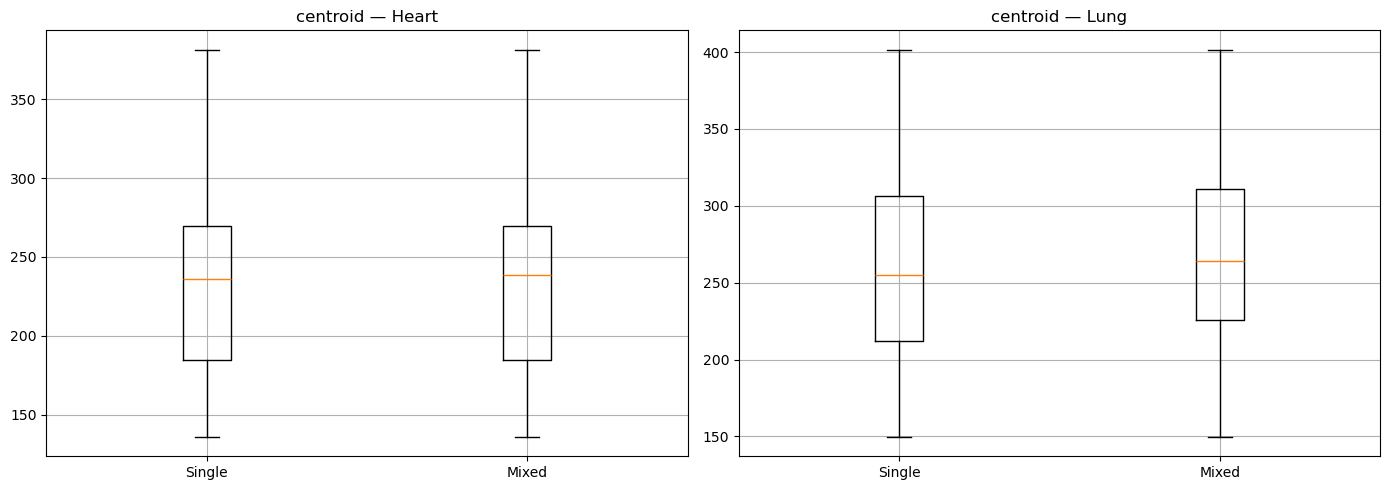

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (pairs, feature, label) in zip(
    axes,
    [
        (hs_feat_pairs, "centroid", "heart"),
        (ls_feat_pairs, "centroid", "lung"),
    ]
):
    single = f"{label}_single_{feature}"
    mixed  = f"{label}_mixed_{feature}"
    ax.boxplot([pairs[single], pairs[mixed]], labels=["Single", "Mixed"])
    ax.set_title(f"{feature} — {label.capitalize()}")
    ax.grid(True)

plt.tight_layout()
plt.show()


## Feature selection

In [10]:
heart_df = build_heart_feature_table(datasets['heart_data'], datasets['mix_heart_data'])
lung_df  = build_lung_feature_table(datasets['lung_data'], datasets['mix_lung_data'])

heart_df.head()
# lung_df.head()

Lung mixed: 100%|██████████| 145/145 [00:01<00:00, 87.80it/s]


,rms,zcr,duration,centroid,bandwidth,rolloff,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,...,mfcc13_std,wavelet_energy_0,wavelet_energy_1,wavelet_energy_2,wavelet_energy_3,wavelet_energy_4,gender,location,sound_type,source_group
0,0.074459,0.054828,15.0,208.694473,250.074400,362.503310,-252.614410,171.117462,40.376202,-3.538653,...,3.370072,0.859268,0.086982,0.045162,0.008277,0.000312,F,RC,Normal,single
1,0.061309,0.027596,15.0,136.024147,201.855902,237.850900,-346.822113,185.239883,40.617916,1.744687,...,3.671264,0.962763,0.031046,0.004826,0.001295,0.000071,F,LC,Normal,single
2,0.055164,0.032454,15.0,160.776509,208.695044,325.410487,-360.882599,163.375870,36.810143,-4.087175,...,2.995969,0.969935,0.023345,0.004213,0.002364,0.000143,M,RUSB,Normal,single
3,0.096815,0.035380,15.0,189.551291,209.495433,355.253575,-290.579681,214.165985,16.891190,-12.841930,...,2.680772,0.869025,0.061682,0.052768,0.016012,0.000514,F,LUSB,Normal,single
4,0.093833,0.039783,15.0,197.265006,204.713746,367.386123,-293.349976,219.907043,27.996780,-20.430805,...,3.753443,0.826268,0.087836,0.062578,0.022693,0.000625,F,LLSB,Normal,single


In [11]:
datasets = {
    "heart": heart_df,
    "lung": lung_df,
}

factors = ["gender", "location", "sound_type"]

anova_results = {
    f"{name}_{factor}": one_way_anova_by_factor(df, factor)
    for name, df in datasets.items()
    for factor in factors
}

significance_df = pd.DataFrame([
    {
        "test": name,
        "significant_count": res["significant"].sum(),
        "percent_significant": 100 * res["significant"].mean(),
    }
    for name, res in anova_results.items()
])

significance_df


,test,significant_count,percent_significant
0,heart_gender,2,5.555556
1,heart_location,24,66.666667
2,heart_sound_type,36,100.000000
3,lung_gender,2,5.555556
4,lung_location,31,86.111111
5,lung_sound_type,34,94.444444


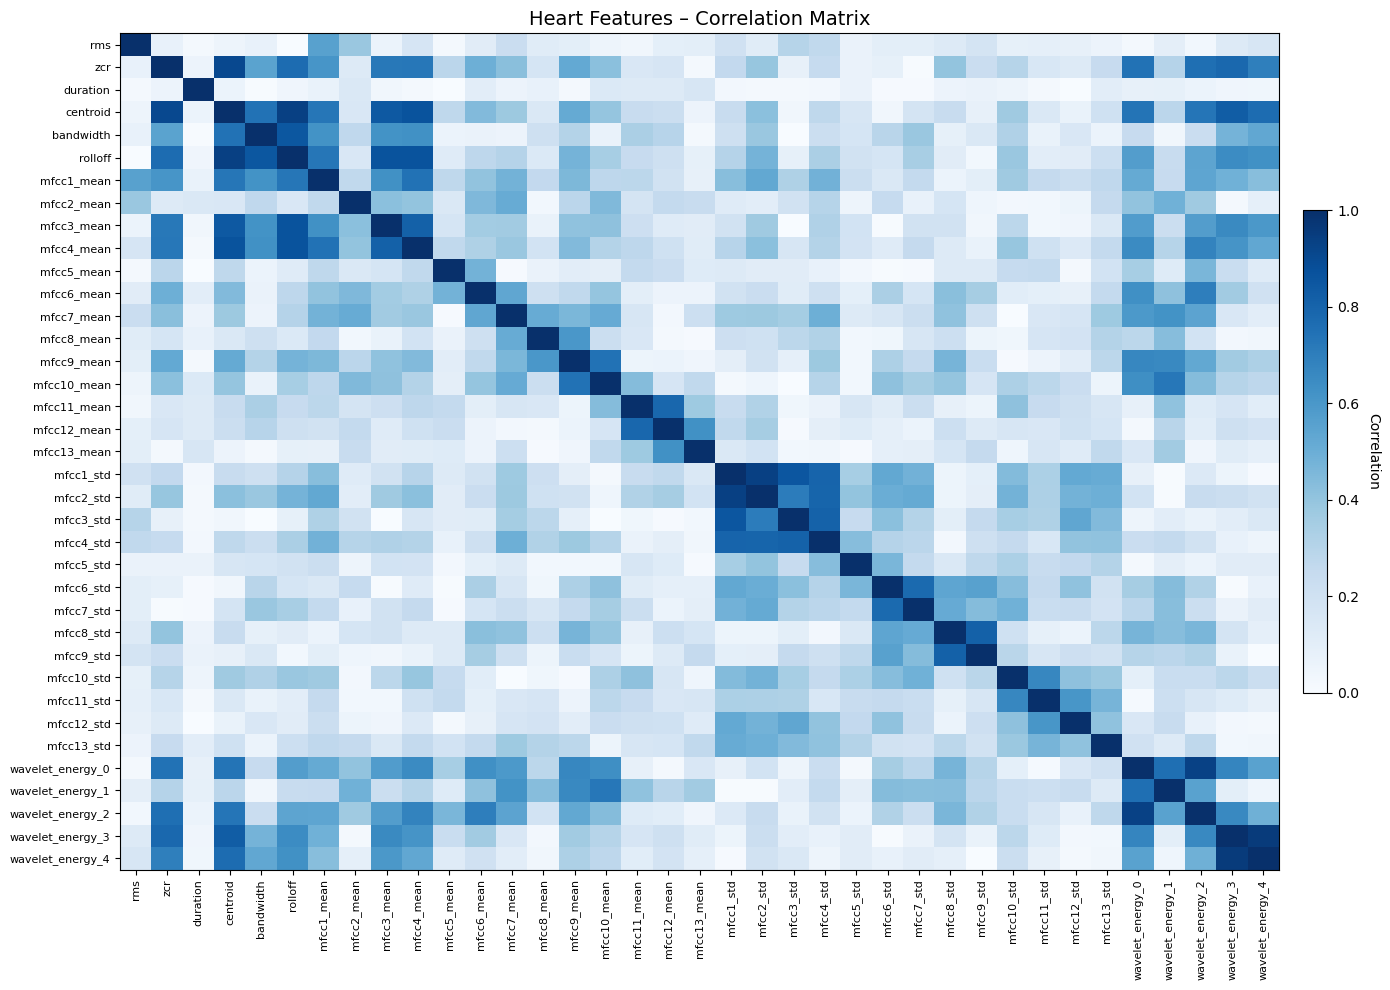

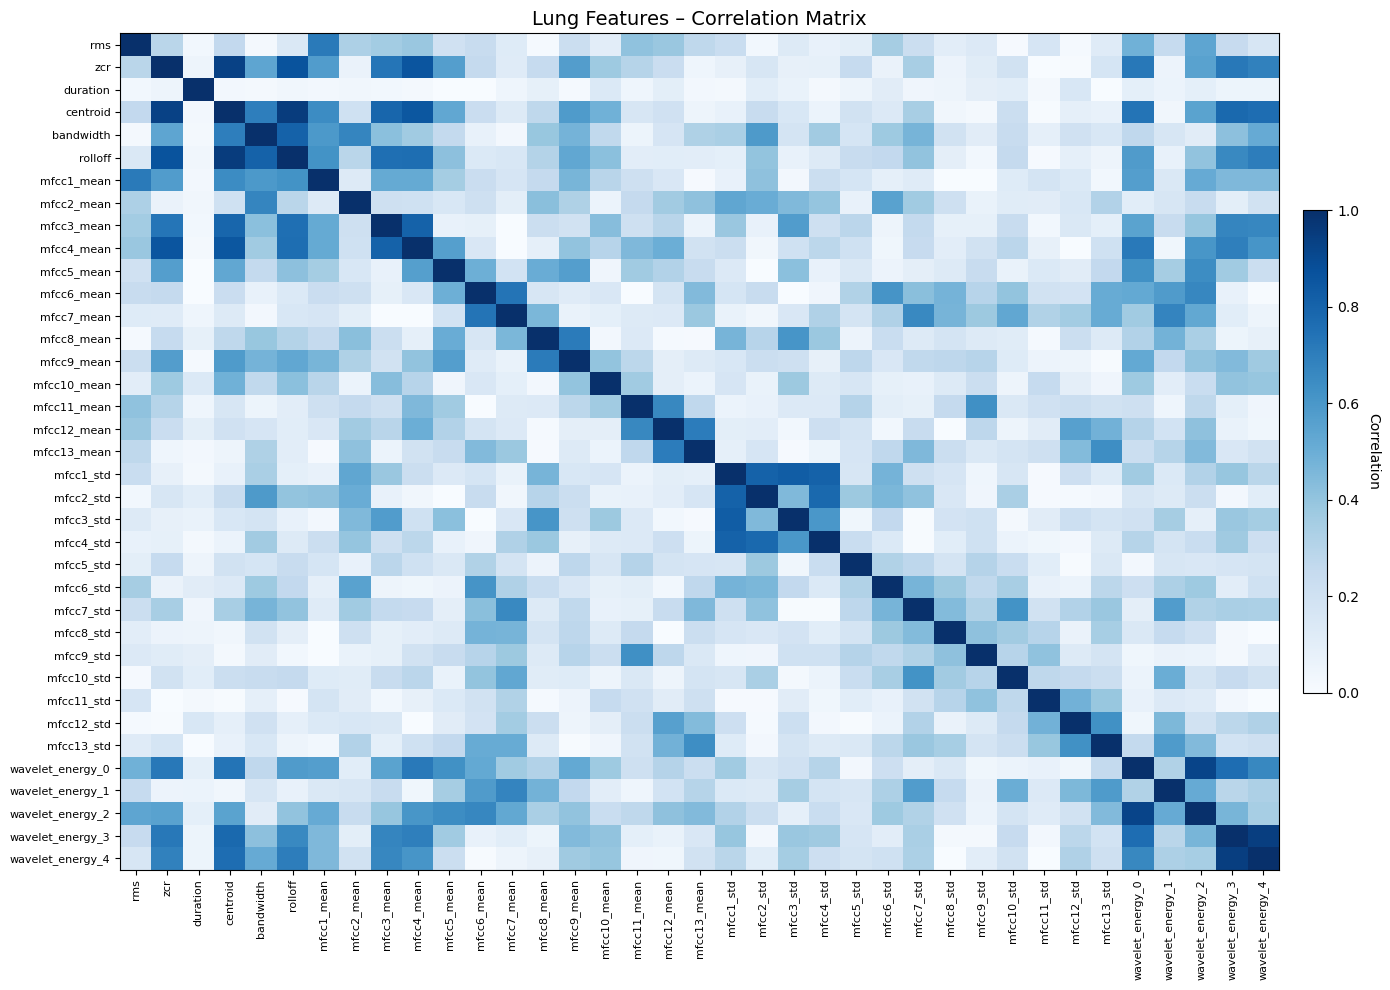

In [12]:


plot_feature_correlation(heart_df, title="Heart Features – Correlation Matrix")
plot_feature_correlation(lung_df, title="Lung Features – Correlation Matrix")

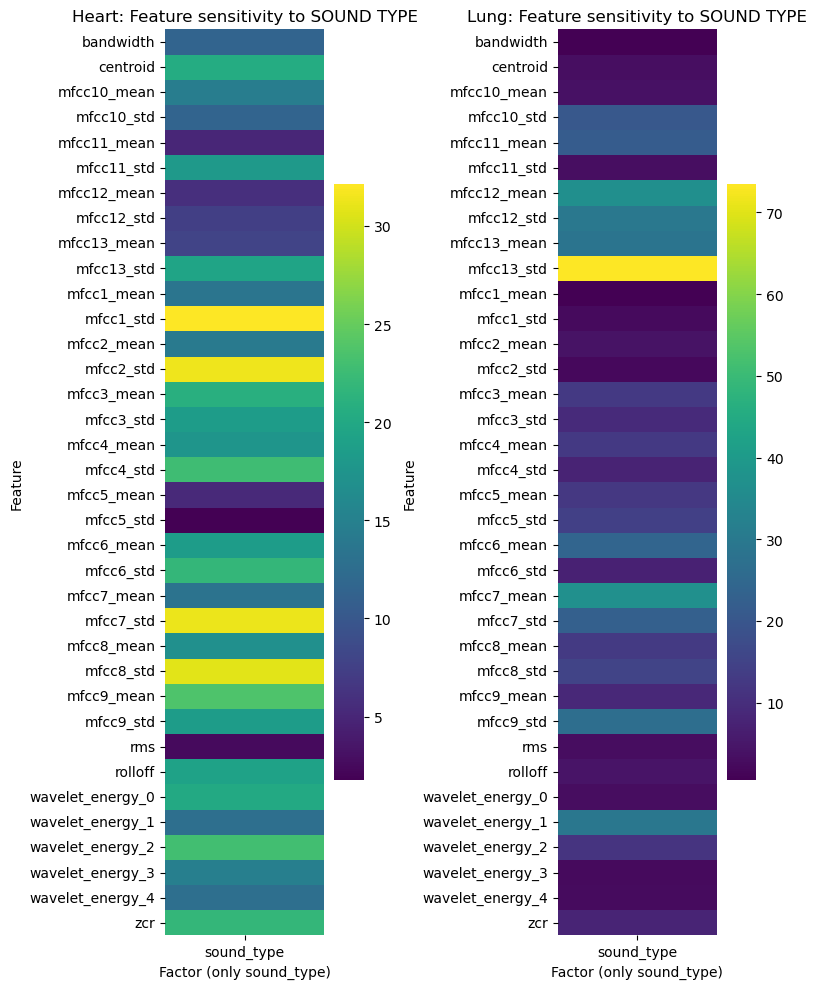

In [17]:
heart_data = [
    ("sound_type", anova_results["heart_sound_type"])
]

lung_data = [
    ("sound_type", anova_results["lung_sound_type"])
]

fig, axes = plt.subplots(1, 2, figsize=(8, 10))

for ax, (data, title) in zip(
    axes,
    [
        (heart_data, "Heart: Feature sensitivity to SOUND TYPE"),
        (lung_data, "Lung: Feature sensitivity to SOUND TYPE"),
    ],
):

    rows = []
    for factor_name, anova_df in data:
        tmp = anova_df.copy()
        tmp["factor"] = factor_name  # now always "sound_type"
        rows.append(tmp)

    combined = pd.concat(rows, ignore_index=True)
    combined["neg_log10_p"] = -np.log10(combined["p_value"])
    
    # Pivot: features = rows, factor="sound_type" = single column
    pivot = combined.pivot_table(
        index="feature",
        columns="factor",
        values="neg_log10_p"
    )

    sns.heatmap(pivot, ax=ax, cmap="viridis")
    ax.set_title(title)
    ax.set_xlabel("Factor (only sound_type)")
    ax.set_ylabel("Feature")
    

plt.tight_layout()
plt.show()
